# **I. Perkenalan**

```
=======================================================================================================================================
Live Code 4

Nama  : Achmed Alridho Zulkarnaen
Batch : RMT-037

File ipynb ini berisi pembuatan machine learning time series yang dapat memprediksi tingkat kepopuleran wisata ke Pulau Pari selama setahun ke depan.
=======================================================================================================================================
```

## Latar Belakang
Saya seorang data scientist di perusahaan travel agent, saya diminta oleh perusahaan untuk melakukan analisis permintaan paket wisata ke Pulau Pari berdasarkan data Google Trends. Data ini menggambarkan tingkat kepopuleran kata kunci "Pulau Pari" di pencarian Google. Dengan menganalisis tren permintaan wisata ke Pulau Pari, saya dapat memperoleh wawasan yang bermanfaat untuk merancang strategi pemasaran dan merumuskan penawaran paket wisata yang lebih relevan.
## Objective
Tujuan dari proyek ini adalah untuk mengembangkan model predict yang dapat memprediksi tingkat kepopuleran wisata ke Pulau Pari selama setahun ke depan, menggunakan data tren pencarian yang tersedia. Model ini bertujuan membantu tim pemasaran dalam menganalisis pola permintaan, merancang strategi promosi yang lebih tepat sasaran, dan mempersiapkan diri untuk mengatasi lonjakan permintaan di masa yang akan datang.

# **II. Import Libraries**

In [1]:
# Import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score,mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pylab
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

# **III. Data Loading**

In [2]:
df_ori = pd.read_csv('multiTimeline.csv',header=1)
df_ts = df_ori.copy()
df_ts

,Week,Pulau Pari: (Indonesia)
0,2022-03-27,16
1,2022-04-03,13
2,2022-04-10,18
3,2022-04-17,29
4,2022-04-24,35
...,...,...
121,2024-07-21,43
122,2024-07-28,34
123,2024-08-04,32
124,2024-08-11,36


In [3]:
# Check info dataset
df_ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Week                     126 non-null    object
 1   Pulau Pari: (Indonesia)  126 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.1+ KB


In [4]:
df_ts.isnull().sum()

Week                       0
Pulau Pari: (Indonesia)    0
dtype: int64

Tidak terdapat missing value data type Week masih salah

In [5]:
# Konversi column Week ke datetime
df_ts['Week'] = pd.to_datetime(df_ts['Week'])

Melakukan konversi column Week ke datetime

Text(0, 0.5, 'Pulau Pari: (Indonesia)')

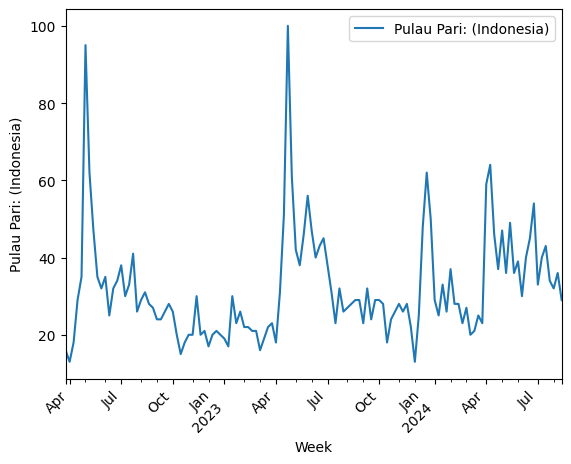

In [6]:
# Plot the data
df_ts.columns = ['Week', 'Pulau Pari: (Indonesia)']
df_ts.set_index('Week',inplace=True)

df_ts.plot()
plt.xlabel('Week')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Pulau Pari: (Indonesia)')

Pada grafik menunjukan Pulau Pari paling diminati di bulan April-Juli

# **IV. Exploratory Data Analysis (EDA)**

## Time Series Decomposition

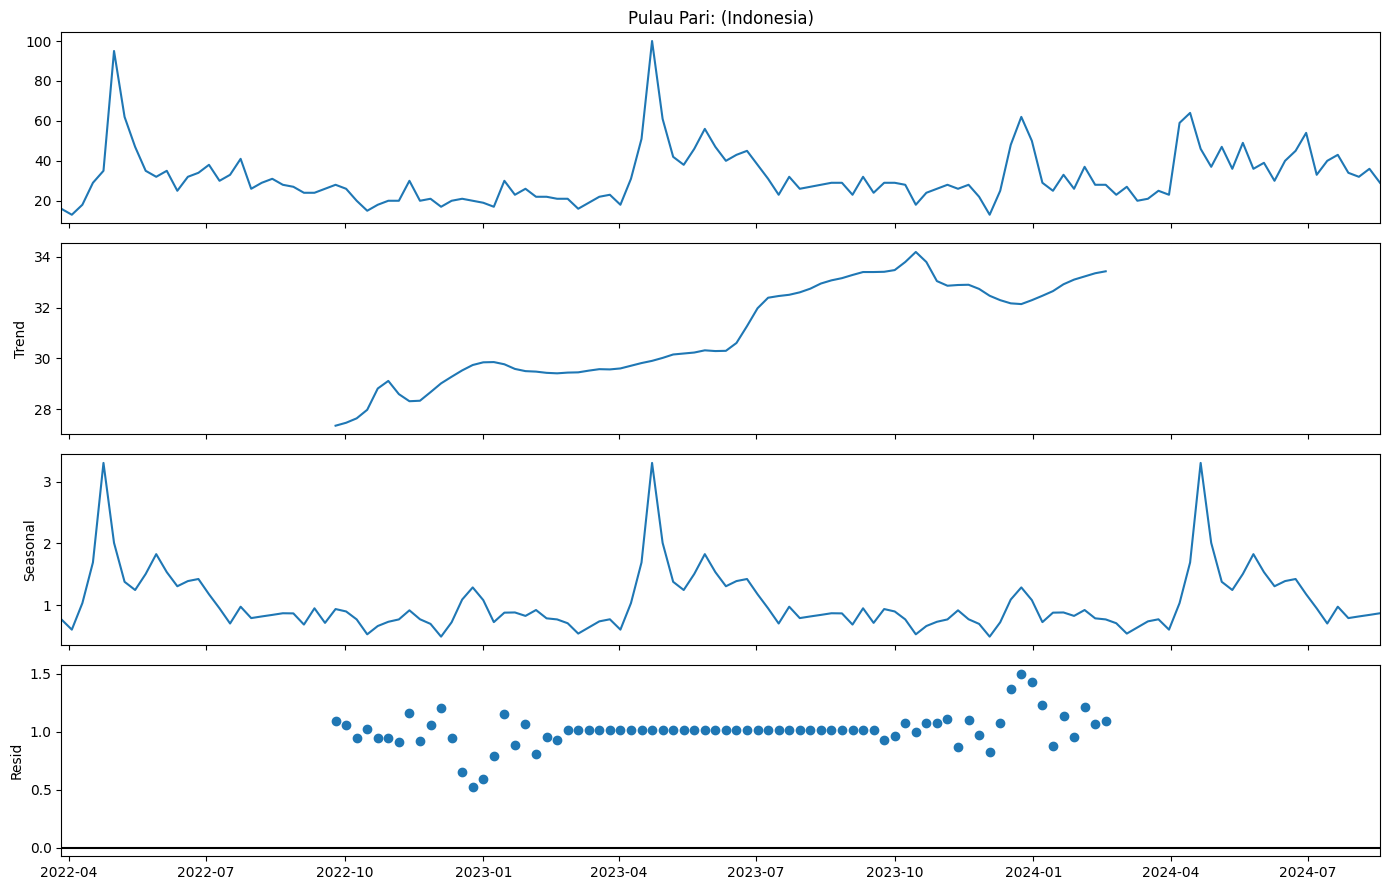

In [7]:
# Decompose komponen dari time series.
pylab.rcParams['figure.figsize'] = (14, 9)
res = seasonal_decompose(df_ts['Pulau Pari: (Indonesia)'], model='multiplicative', period= 52)
ax=res.plot()
plt.show()

Dekomposisi data menunjukkan bahwa popularitas wisata ke Pulau Pari dipengaruhi oleh tren jangka panjang yang berfluktuasi, dengan lonjakan pencarian pada awal periode yang kemudian menurun. Pola musiman menunjukkan variasi yang teratur sepanjang tahun, dengan puncak pencarian yang terjadi secara periodik, kemungkinan besar dipengaruhi oleh faktor musiman seperti liburan. Residual atau sisa data menunjukkan sedikit variabilitas yang tidak dapat dijelaskan oleh tren atau pola musiman, yang menunjukkan bahwa model telah mampu menangkap sebagian besar fluktuasi dalam data.

## Stationary

### A. Without Differencing

In [8]:
# Membuat fungsi untuk check stationarity
def check_stationarity(series):
    result = adfuller(series.values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [9]:
check_stationarity(df_ts['Pulau Pari: (Indonesia)'])

ADF Statistic: -3.893116
p-value: 0.002086
Critical Values:
	1%: -3.485
	5%: -2.886
	10%: -2.580
Stationary


Hasil uji ADF menunjukkan bahwa data sudah stasioner. P-value sebesar 0.002086 lebih kecil dari 0.05, yang berarti hipotesis nol (data tidak stasioner) dapat ditolak. Selain itu, ADF Statistic -3.893116 lebih kecil dari nilai kritis pada level 1% : -3.485, yang semakin mengonfirmasi bahwa data bersifat stasioner. Dengan kata lain, data yang dianalisis tidak menunjukkan adanya tren atau pola musiman yang berubah seiring waktu.

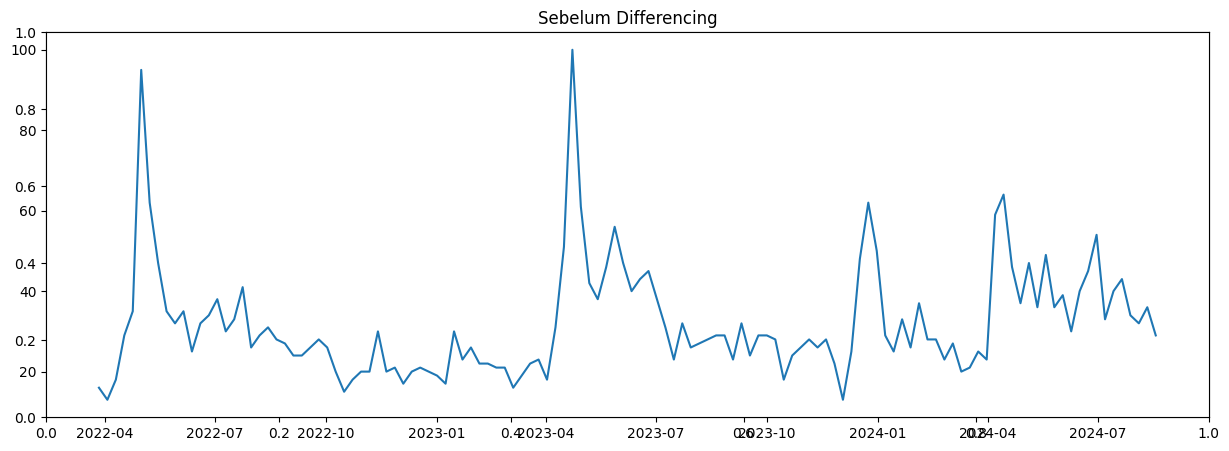

In [10]:
# Plot sebelum differencing
fig, ax = plt.subplots(figsize=(15,5))
ax1 = fig.add_subplot(111)
ax1.set_title('Sebelum Differencing')
ax1.plot(df_ts['Pulau Pari: (Indonesia)'])

## ACF & PACF

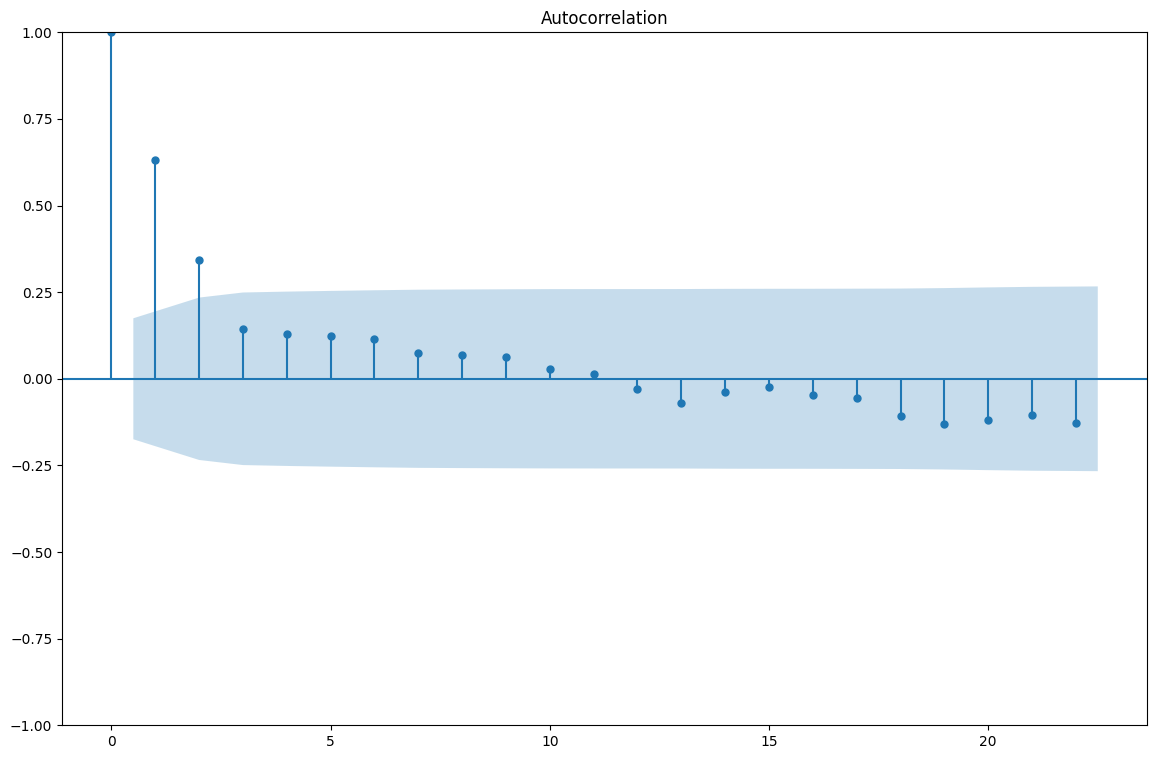

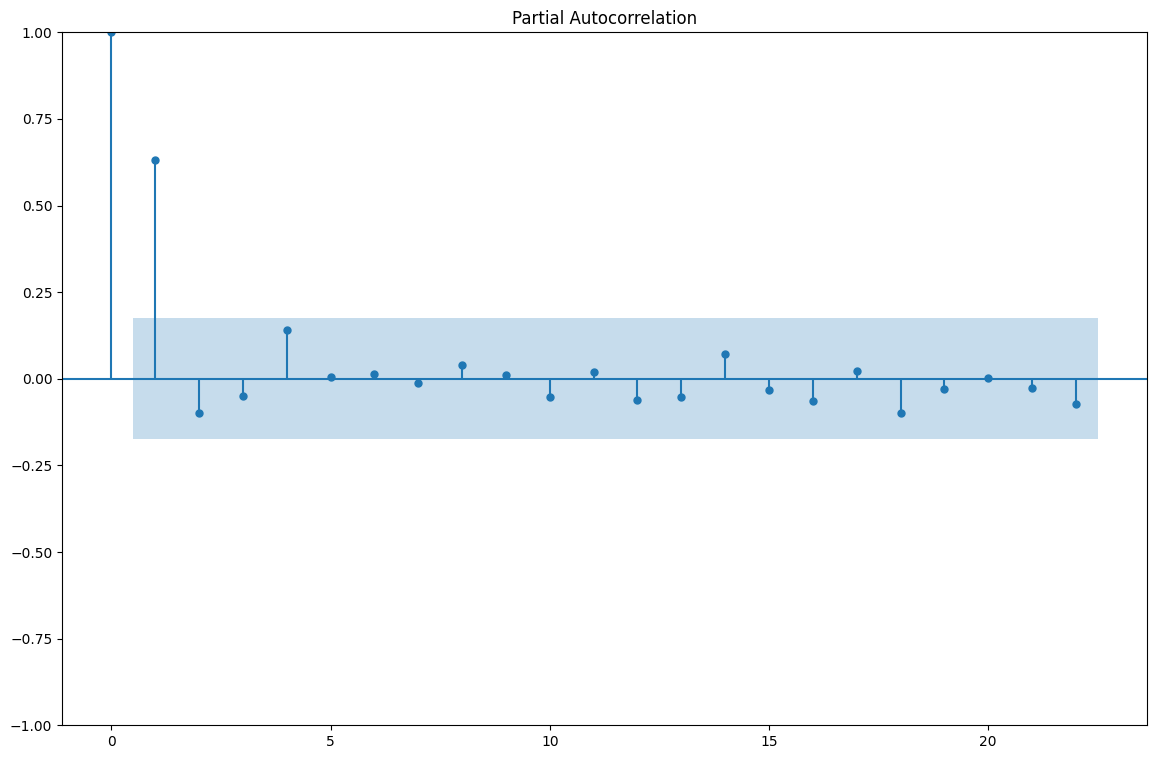

In [11]:
# Plot ACF & PACF dari dataset
plot_acf(df_ts['Pulau Pari: (Indonesia)'])
plot_pacf(df_ts['Pulau Pari: (Indonesia)'])
plt.show()

Berdasarkan analisis grafik ACF dan PACF, saya memutuskan untuk menggunakan model ARIMA(1, 0, 2). Artinya, saya memilih p = 1, yang menunjukkan bahwa data memiliki ketergantungan jangka pendek pada nilai sebelumnya (lag 1), d = 0 karena data sudah stasioner dan tidak perlu dilakukan differencing lebih lanjut, serta q = 2, yang menunjukkan bahwa ada ketergantungan pada dua lag sebelumnya di bagian moving average.
* p = 1
* d = 0
* q = 2

Ini berarti model ARIMA yang disarankan adalah ARIMA(1, 0, 2).

# **V. Model Definition and Training**

### A. ARIMA

In [12]:
len(df_ts)

126

Ada 126 data

In [13]:
# Splitting dataset
train_size = int(len(df_ts) * 0.75)  # 75% untuk training
train = df_ts[:train_size]
test = df_ts[train_size:]
print('Train size : ', train.shape)
print('Test size : ', test.shape)

Train size :  (94, 1)
Test size :  (32, 1)


Saya split 75% 25% antara train dan test

In [14]:
# Stationarity check
check_stationarity(train['Pulau Pari: (Indonesia)'])

ADF Statistic: -3.286548
p-value: 0.015491
Critical Values:
	1%: -3.505
	5%: -2.894
	10%: -2.584
Stationary


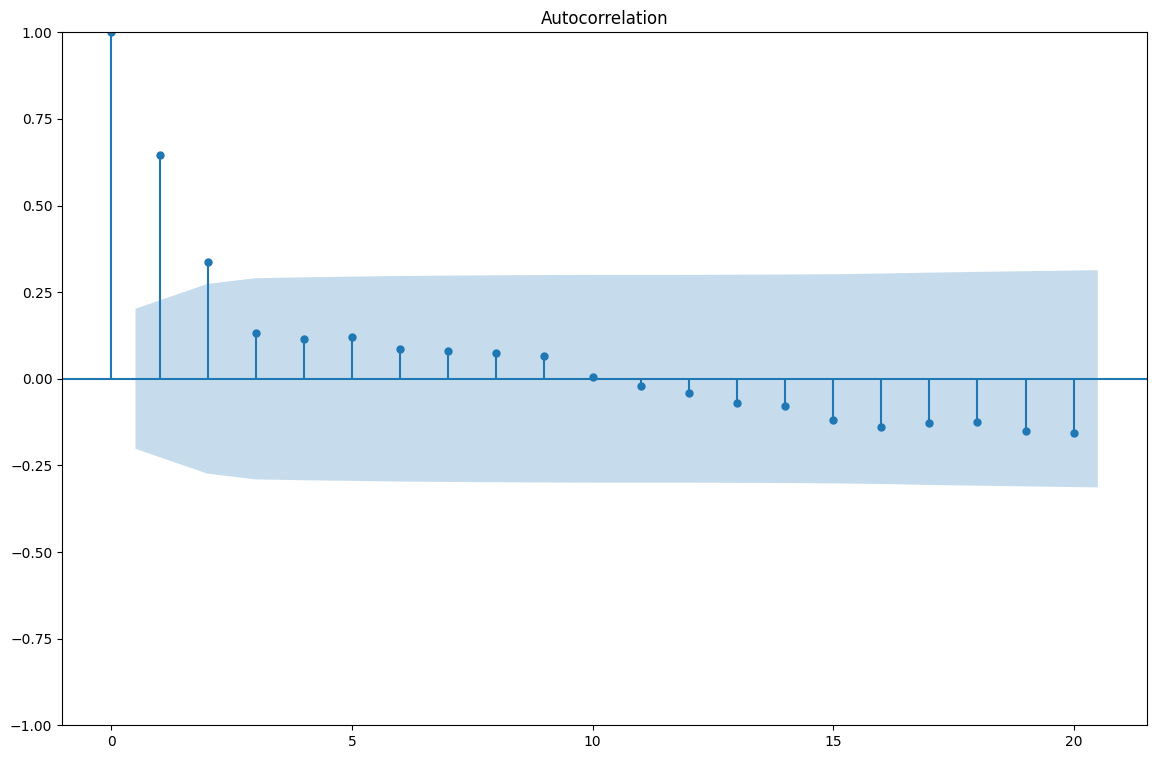

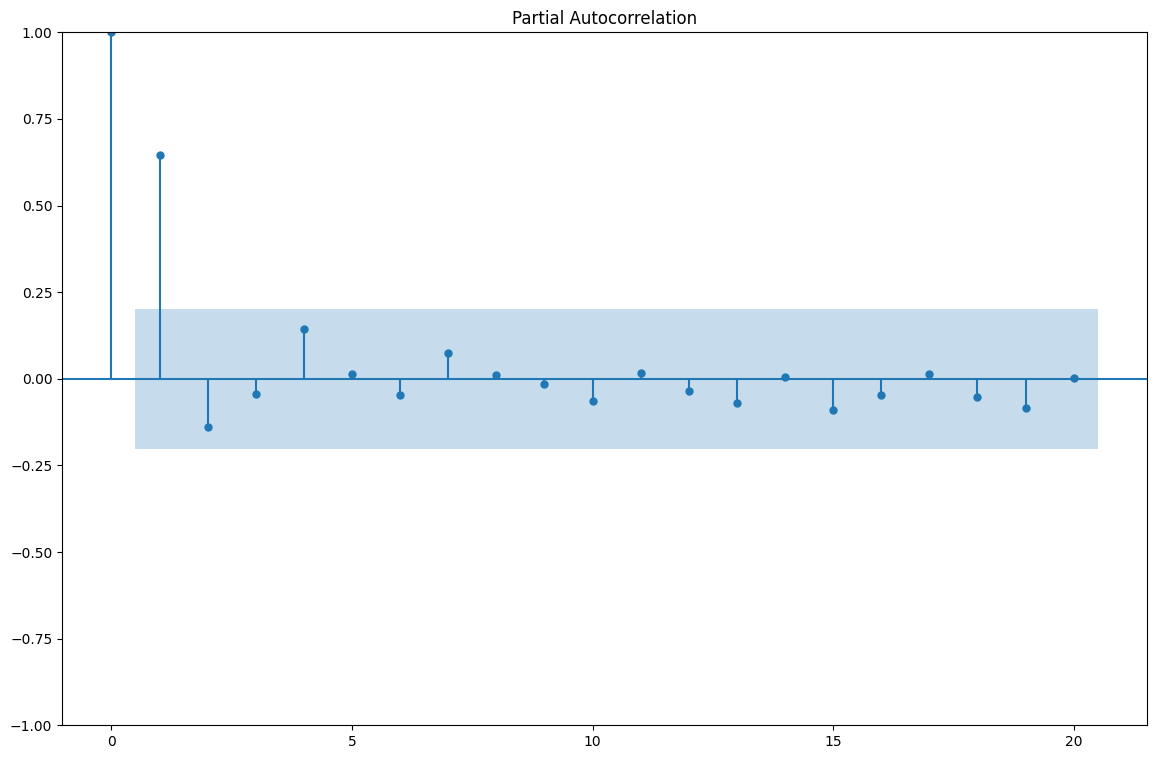

In [15]:
# Check plot ACF & PACF
plot_acf(train['Pulau Pari: (Indonesia)'])
plot_pacf(train['Pulau Pari: (Indonesia)'])
plt.show()

Berdasarkan analisis autocorrelation dan partial autocorrelation, terlihat bahwa data tidak menunjukkan pola musiman atau tren panjang yang signifikan. Nilai autocorrelation dan partial autocorrelation sudah sangat kecil setelah lag 1, jadi bisa disimpulkan bahwa d = 0, artinya data sudah stasioner dan tidak perlu dilakukan differencing lagi. Model ARIMA bisa langsung diterapkan tanpa perubahan lebih lanjut pada differencing.

In [16]:
# Train with p=1, d=0, q=2
arima = ARIMA(train, order=(1, 0, 2))
mod_train = arima.fit()
mod_train.aic

np.float64(724.983277652345)

Setelah melatih model ARIMA dengan parameter p=1, d=0, q=2 pada data training, diperoleh nilai AIC sebesar 724.9. Ini menunjukkan bahwa model cukup baik dalam menyesuaikan data, dengan AIC yang relatif rendah, menandakan keseimbangan yang baik antara kompleksitas model dan kemampuan memprediksi data.

In [17]:
print(test.index.min())
print(test.index.max())

2024-01-14 00:00:00
2024-08-18 00:00:00


Data test mencakup periode dari 14 Januari 2024 hingga 18 Agustus 2024, yang memberikan rentang waktu yang cukup panjang untuk menguji akurasi prediksi model.

In [18]:
# Predict test-set
ari_pred_test = mod_train.predict(start=test.index.min(), end=test.index.max(), dynamic=True)
ari_pred_test = pd.DataFrame(ari_pred_test)
ari_pred_test.columns = ['Pulau Pari: (Indonesia) Predict']
# Concate with actual test-set
act_vs_pred_ari=pd.concat([test, ari_pred_test], axis=1)
act_vs_pred_ari

,Pulau Pari: (Indonesia),Pulau Pari: (Indonesia) Predict
2024-01-14,25,24.247129
2024-01-21,33,25.798747
2024-01-28,26,29.530926
2024-02-04,37,30.267441
2024-02-11,28,30.412786
2024-02-18,28,30.441469
2024-02-25,23,30.447129
2024-03-03,27,30.448246
2024-03-10,20,30.448466
2024-03-17,21,30.448510


### B. SARIMA

In [19]:
# Splitting dataset
train_size = int(len(df_ts) * 0.75)  # 75% untuk training
train = df_ts[:train_size]
test = df_ts[train_size:]
print('Train size : ', train.shape)
print('Test size : ', test.shape)

Train size :  (94, 1)
Test size :  (32, 1)


Untuk SARIMA saya akan coba split train test 75% 25%

In [20]:
train

,Pulau Pari: (Indonesia)
Week,
2022-03-27,16
2022-04-03,13
2022-04-10,18
2022-04-17,29
2022-04-24,35
...,...
2023-12-10,25
2023-12-17,48
2023-12-24,62


In [21]:
test

,Pulau Pari: (Indonesia)
Week,
2024-01-14,25
2024-01-21,33
2024-01-28,26
2024-02-04,37
2024-02-11,28
2024-02-18,28
2024-02-25,23
2024-03-03,27
2024-03-10,20


Tanggal sudah berurutan

In [22]:
# Train menggunakan SARIMAX
sar=SARIMAX(train, order=(1, 0, 2),seasonal_order=(1, 0, 2, 52)).fit()
sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:            Pulau Pari: (Indonesia)   No. Observations:                   94
Model:             SARIMAX(1, 0, 2)x(1, 0, 2, 52)   Log Likelihood                -365.283
Date:                            Mon, 18 Nov 2024   AIC                            744.566
Time:                                    11:42:58   BIC                            762.369
Sample:                                03-27-2022   HQIC                           751.757
                                     - 01-07-2024                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9834      0.042     23.171      0.000       0.900       1.067
ma.L1         -0.2608      0.165     -1.585      0.113      -0.583       0.062
ma.L2         -0.3035      0.233     -1.302      0.193      -0.760       0.153
ar.S.L52       0.8530    244.365      0.003      0.997    -478.093     479.799
ma.S.L52      -1.3796    439.651     -0.003      0.997    -863.079     860.320
ma.S.L104      0.9612    151.226      0.006      0.995    -295.436     297.358
sigma2        60.6297     10.180      5.956      0.000      40.677      80.583
===================================================================================
Ljung-Box (L1) (Q):                   0.41   Jarque-Bera (JB):              1051.62
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):               0.36   Skew:                             3.28
Prob(H) (two-sided):                  0.01   Kurtosis:                        18.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.04e+20. Standard errors may be unstable.
"""

In [23]:
sar.aic

np.float64(744.5661906314914)

Hasil AIC dari model SARIMA sebesar 744.57 menunjukkan bahwa model ini memiliki kualitas yang baik dalam hal fit terhadap data, karena AIC yang lebih rendah menandakan model yang lebih efisien. Dengan nilai AIC ini, model SARIMA sudah menunjukkan performa yang wajar, namun masih ada ruang untuk penyempurnaan lebih lanjut.

In [24]:
# Predict test-set
sar_pred_test = sar.predict(start=test.index.min(), end=test.index.max(), dynamic=True)
sar_pred_test = pd.DataFrame(sar_pred_test)
sar_pred_test.columns = ['Pulau Pari: (Indonesia) Predict']

# Concate with actual test-set
act_vs_pred_sar=pd.concat([test, sar_pred_test], axis=1)
act_vs_pred_sar

,Pulau Pari: (Indonesia),Pulau Pari: (Indonesia) Predict
2024-01-14,25,31.614119
2024-01-21,33,35.056724
2024-01-28,26,34.661212
2024-02-04,37,34.197427
2024-02-11,28,33.787600
2024-02-18,28,33.376004
2024-02-25,23,32.984773
2024-03-03,27,32.547062
2024-03-10,20,32.207358
2024-03-17,21,30.780595


# **VI. Model Evaluation**

## ARIMA

In [25]:
# Check the MAE & MAPE ARIMA
print('MAE test  : ', mean_absolute_error(test, ari_pred_test))
print('MAPE test : ', mean_absolute_percentage_error(test, ari_pred_test))
print('R2 Test: ', r2_score(test, ari_pred_test))

MAE test  :  9.080778940177602
MAPE test :  0.23328750191909475
R2 Test:  -0.24952018986169833


Hasil evaluasi model ARIMA menunjukkan bahwa MAE sebesar 9.08 dan MAPE sebesar 23.33% mengindikasikan bahwa prediksi model memiliki kesalahan yang cukup signifikan, dengan rata-rata kesalahan sekitar 9 unit dan kesalahan relatif sekitar 23%. Nilai R2 yang negatif -0.25 menunjukkan bahwa model ini tidak dapat menjelaskan variabilitas data dengan baik. ARIMA masih perlu perbaikan untuk mencapai prediksi yang lebih akurat dan dapat diandalkan.

## SARIMA

In [26]:
# Check the MAE & MAPE SARIMA
print('MAE test  : ', mean_absolute_error(test, sar_pred_test))
print('MAPE test : ', mean_absolute_percentage_error(test, sar_pred_test))
print('R2 Test: ', r2_score(test, sar_pred_test))

MAE test  :  8.714631839175585
MAPE test :  0.23581588025467567
R2 Test:  -0.18508895110729906


Hasil evaluasi model SARIMA menunjukkan MAE sebesar 8.71, yang berarti kesalahan prediksi rata-rata sekitar 8.71 unit. MAPE sebesar 23.58% menunjukkan bahwa kesalahan relatif model sekitar 23%, yang masih cukup signifikan. Nilai R2 yang negatif -0.19 mengindikasikan bahwa model tidak dapat menjelaskan variabilitas data dengan baik, meskipun model SARIMA memberikan hasil yang lebih baik dibandingkan dengan model ARIMA, masih ada ruang untuk perbaikan agar model bisa lebih akurat dalam memprediksi data.

# **VII. Model Inference**

In [27]:
print(df_ts.index.min())
print(df_ts.index.max())

2022-03-27 00:00:00
2024-08-18 00:00:00


* Data berakhir di 2024-08-18 maka predik dimulai dari 2024-08-19

### Prediksi 1 Tahun Kedepan

In [28]:
sar_pred_inf = sar.predict(start='2024-08-19', end='2025-08-19', dynamic=True)
sar_pred_inf = pd.DataFrame(sar_pred_inf)
sar_pred_inf.columns = ['Pulau Pari: (Indonesia) Predict']
sar_pred_inf

,Pulau Pari: (Indonesia) Predict
2024-08-25,27.364300
2024-09-01,25.825502
2024-09-08,25.700256
2024-09-15,26.350130
2024-09-22,27.085310
2024-09-29,26.039140
2024-10-06,23.236549
2024-10-13,20.820293
2024-10-20,22.016305
2024-10-27,22.752683


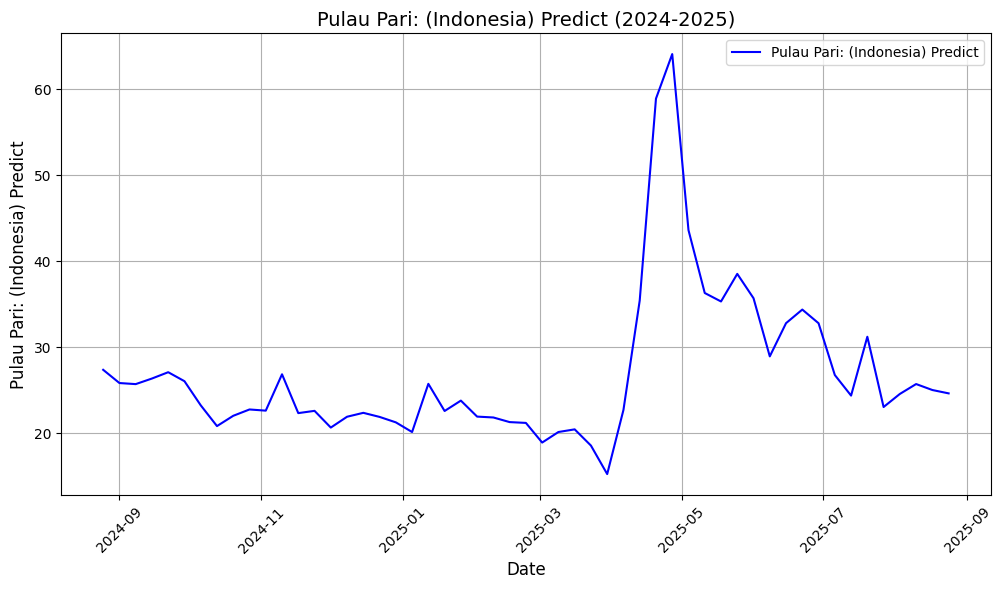

In [29]:
# Hasil prediksi dalam bentuk Line Chart
plt.figure(figsize=(12,6))
plt.plot(sar_pred_inf.index, sar_pred_inf['Pulau Pari: (Indonesia) Predict'], label='Pulau Pari: (Indonesia) Predict', color='b')
plt.title('Pulau Pari: (Indonesia) Predict (2024-2025)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Pulau Pari: (Indonesia) Predict', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.show()

* Berdasarkan grafik prediksi minat wisata ke Pulau Pari selama setahun ke depan, terlihat bahwa ada penurunan yang cukup jelas dalam kepopulerannya dari 2024 hingga 2025, meskipun ada fluktuasi pada beberapa periode. Puncak minat terlihat pada awal 2025, yang mungkin dipengaruhi oleh faktor musiman atau kejadian khusus. Hal ini memberikan insight bagi tim pemasaran untuk fokus pada periode puncak minat tersebut dan menyiapkan strategi promosi yang lebih terarah untuk meningkatkan kunjungan selama periode lainnya.

# **VIII. Pengambilan Kesimpulan**

### Jawaban Objective
* Berdasarkan analisis yang telah dilakukan, model prediksi yang dibangun berhasil memberikan wawasan mengenai tren permintaan wisata ke Pulau Pari selama satu tahun ke depan. Dengan menggunakan data Google Trends, model ini menunjukkan fluktuasi minat yang dipengaruhi oleh faktor musiman, serta prediksi penurunan permintaan di sebagian besar periode 2025, dengan puncak permintaan yang diprediksi terjadi di awal tahun. Temuan ini memberikan panduan bagi tim pemasaran untuk merencanakan kampanye promosi yang lebih efektif, menargetkan periode puncak minat, dan mempersiapkan strategi untuk menghadapi penurunan permintaan. Dengan informasi ini, perusahaan dapat mengoptimalkan penawaran paket wisata dan meningkatkan keterlibatan nasabah.

### Kesimpulan Hasil Evaluasi
* Hasil evaluasi model ARIMA dan SARIMA menggunakan MAE (Mean Absolute Error) dan MAPE (Mean Absolute Percentage Error) menunjukkan bahwa kedua model memiliki kesalahan prediksi yang cukup signifikan. Untuk ARIMA, MAE mencapai 9.08 dan MAPE sekitar 23%, sementara untuk SARIMA, MAE sedikit lebih rendah di 8.71 dan MAPE sekitar 23.5%. MAPE ini memberikan gambaran kesalahan relatif, yang berarti rata-rata kesalahan prediksi berkisar 23% dari nilai aktual. Meskipun kedua model memberikan prediksi yang cukup baik, kesalahan yang terjadi masih cukup tinggi untuk dapat diandalkan dalam pengambilan keputusan yang lebih strategis. Oleh karena itu, meskipun MAPE memberikan wawasan yang bermanfaat, model ini masih membutuhkan perbaikan untuk meningkatkan akurasi dan keandalannya.

### Kelebihan dan Kekurangan Model
* Kelebihan dari model ARIMA dan SARIMA adalah keduanya berhasil mengidentifikasi pola umum dalam data dan memberikan prediksi berdasarkan tren historis dan musiman. Namun, kekurangannya adalah model ini kurang efektif dalam menangani fluktuasi besar atau outlier yang mungkin terjadi, seperti lonjakan permintaan yang tidak terduga. Dengan nilai R2 yang negatif pada kedua model, menunjukkan bahwa model masih belum dapat menjelaskan variabilitas data dengan baik. Model ini dapat dioptimalkan lebih lanjut dengan penambahan fitur atau penggunaan teknik lain yang lebih kompleks untuk memperbaiki prediksi dan meningkatkan akurasi dalam menangani fluktuasi yang lebih besar.

### Kesimpulan EDA
* Dari hasil EDA, saya bisa menyimpulkan bahwa tren pencarian untuk Pulau Pari menunjukkan fluktuasi yang cukup besar, dengan lonjakan pencarian yang terjadi pada waktu-waktu tertentu (April-Juli), kemungkinan besar karena musim liburan atau faktor lainnya. Ada pola musiman yang jelas terlihat, yang bisa dimanfaatkan untuk merencanakan promosi yang tepat waktu. Selain itu, ada variasi dalam jumlah pencarian yang bisa menjadi peluang untuk membuat penawaran paket wisata yang sesuai dengan permintaan. Walaupun ada beberapa outlier yang mempengaruhi hasil, secara keseluruhan, permintaan wisata ke Pulau Pari sangat dipengaruhi oleh waktu dan musim. EDA ini memberi wawasan yang sangat berguna untuk merancang strategi pemasaran yang lebih efektif dan tepat sasaran.